In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

1.13.1+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 8.3 MB/s eta 0:00:00


In [2]:
# Here process the tabular data to be graph
import pandas as pd
import numpy as np
import io
from google.colab import files

In [3]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['heart.csv']))
df['ID'] = np.arange(len(df))
df.head()

Saving heart.csv to heart.csv


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,ID
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,3
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,4


In [4]:
# Sort to define the order of nodes
sorted_df = df.sort_values(by="ID")
sorted_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,ID
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,3
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,4


In [5]:
# Select node features
node_features = sorted_df[["age", "sex", "trtbps", "chol", "thalachh", "oldpeak", "fbs", "restecg", "exng", "slp", "caa", "thall"]]
node_features.head()

,age,sex,trtbps,chol,thalachh,oldpeak,fbs,restecg,exng,slp,caa,thall
0,63,1,145,233,150,2.3,1,0,0,0,0,1
1,37,1,130,250,187,3.5,0,1,0,0,0,2
2,41,0,130,204,172,1.4,0,0,0,2,0,2
3,56,1,120,236,178,0.8,0,1,0,2,0,2
4,57,0,120,354,163,0.6,0,1,1,2,0,2


In [6]:
# Get one hot encoding of columns fbs
one_hot_fbs = pd.get_dummies(node_features['fbs']) 
one_hot_fbs = one_hot_fbs.rename({0: 'No_fbs', 1: 'Yes_fbs'}, axis='columns')
one_hot_fbs.head()

,No_fbs,Yes_fbs
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


In [7]:
# Get one hot encoding of columns restecg
one_hot_restecg = pd.get_dummies(node_features['restecg']) 
one_hot_restecg = one_hot_restecg.rename({0: 'normal', 1: 'abnormal_1', 2:'abnormal_2'}, axis='columns')
one_hot_restecg.head()

,normal,abnormal_1,abnormal_2
0,1,0,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


In [8]:
# Get one hot encoding of columns exng
one_hot_exng = pd.get_dummies(node_features['exng']) 
one_hot_exng = one_hot_exng.rename({0: 'No_angina', 1: 'Yes_angina'}, axis='columns')
one_hot_exng.head()

,No_angina,Yes_angina
0,1,0
1,1,0
2,1,0
3,1,0
4,0,1


In [9]:
# Get one hot encoding of columns slp	
one_hot_slp	 = pd.get_dummies(node_features['slp']) 
one_hot_slp = one_hot_slp.rename({0: 'ST_unsloping', 1: 'ST_flat', 2:'ST_downsloping'}, axis='columns')
one_hot_slp.head()

,ST_unsloping,ST_flat,ST_downsloping
0,1,0,0
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [10]:
# Get one hot encoding of columns caa	
one_hot_caa	 = pd.get_dummies(node_features['caa']) 
one_hot_caa = one_hot_caa.rename({0: 'caa_1', 1: 'caa_2', 2:'caa_3', 3:'caa_4', 4:'caa_5'}, axis='columns')
one_hot_caa.head()

,caa_1,caa_2,caa_3,caa_4,caa_5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [11]:
# Get one hot encoding of columns thall
one_hot_thall	 = pd.get_dummies(node_features['thall']) 
one_hot_thall = one_hot_thall.rename({0: 'thall_null', 1: 'thall_fixed_defect', 2:'thall_normal', 3:'thall_reversable defect'}, axis='columns')
one_hot_thall.head()

,thall_null,thall_fixed_defect,thall_normal,thall_reversable defect
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [12]:
encoded_df = pd.concat([node_features, one_hot_fbs, one_hot_restecg, one_hot_exng, one_hot_slp, one_hot_caa, one_hot_thall], axis=1)
encoded_df = encoded_df.drop(['thalachh','fbs','restecg','exng','slp','caa','thall'], axis=1)
encoded_df.head()

,age,sex,trtbps,chol,oldpeak,No_fbs,Yes_fbs,normal,abnormal_1,abnormal_2,...,ST_downsloping,caa_1,caa_2,caa_3,caa_4,caa_5,thall_null,thall_fixed_defect,thall_normal,thall_reversable defect
0,63,1,145,233,2.3,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,1,130,250,3.5,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,41,0,130,204,1.4,1,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
3,56,1,120,236,0.8,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0
4,57,0,120,354,0.6,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [13]:
# Convert to numpy: the node feature matrix
encoded_df_np = encoded_df.to_numpy()
encoded_df_np.shape 

(303, 24)

In [16]:
#labels
# Select node features
labels = sorted_df[["output"]]  
labels.head()

,output
0,1
1,1
2,1
3,1
4,1


In [17]:
# Convert to numpy
labels_np = labels.to_numpy()
labels_np.shape # [num_nodes, 1] --> node regression

(303, 1)

In [35]:
# Remap patient IDs
df["'ID'"] = df.reset_index().index

In [36]:
import itertools

categories = df["output"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))

for category in categories:
    category_df = df[df["output"] == category]
    Patients = category_df["ID"].values
    # Build all combinations, as all players are connected
    permutations = list(itertools.combinations(Patients, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    category_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, category_edges])

# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
edge_index # [2, num_edges]

array([[  0,   0,   0, ..., 300, 300, 301],
       [  1,   2,   3, ..., 301, 302, 302]])

In [37]:
from torch_geometric.data import Data
data = Data(x=encoded_df_np, edge_index=edge_index, y=labels_np)

From here we do a visual of the graph

In [38]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected = True)
visualize_graph(G, color=data.y)

AttributeError: ignored

Then we try to mask the train data, test data to enalbe the training.

The next block will define the GCN model


In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


### Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

Embedding shape: [34, 2]


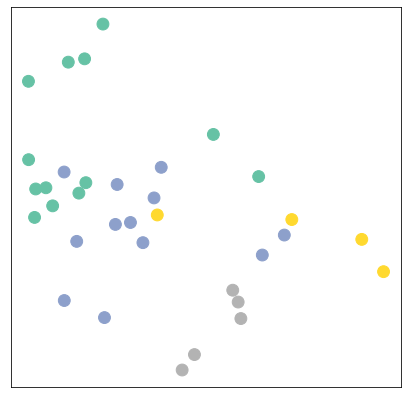

In [ ]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observse how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you. 
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

<IPython.core.display.Javascript object>

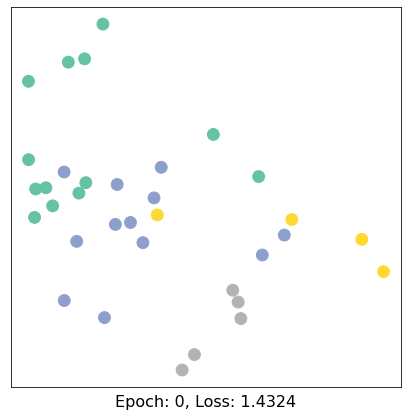

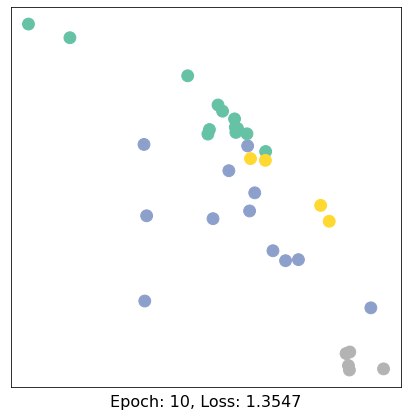

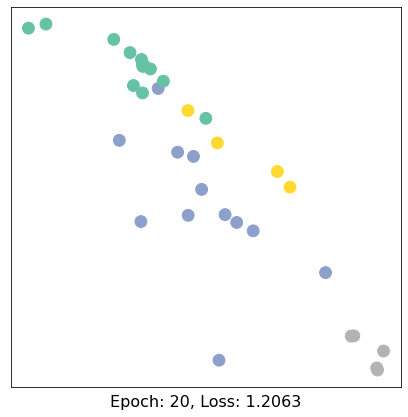

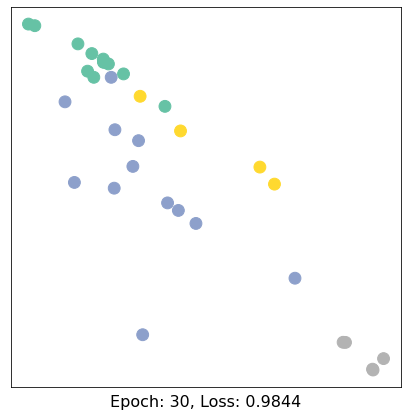

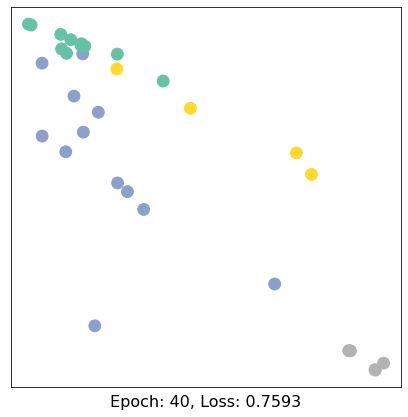

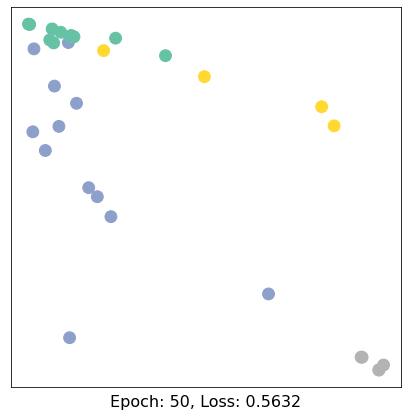

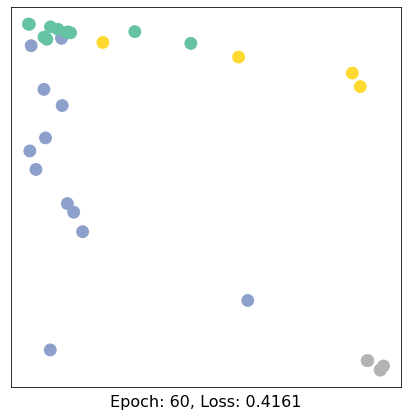

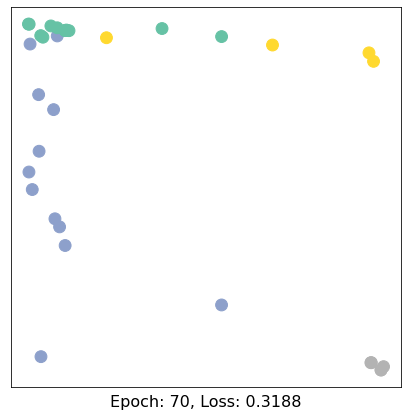

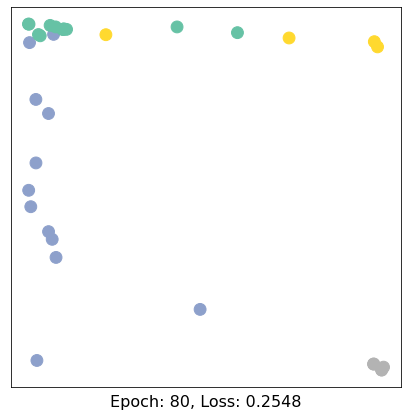

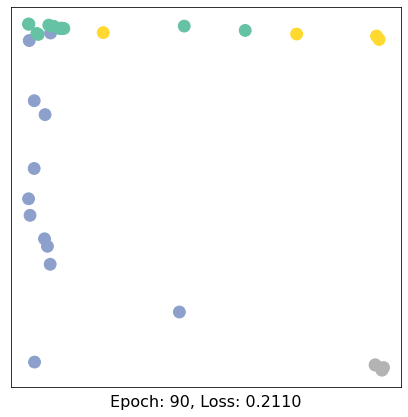

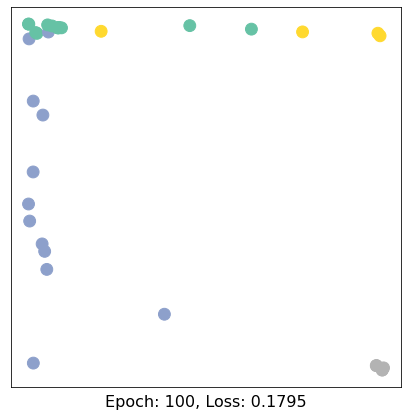

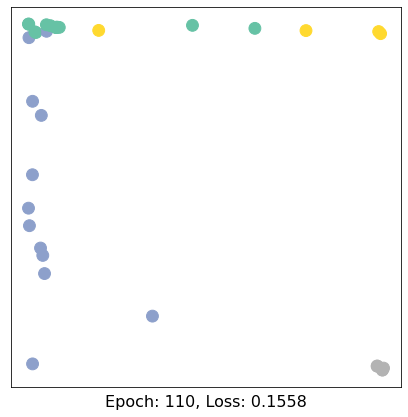

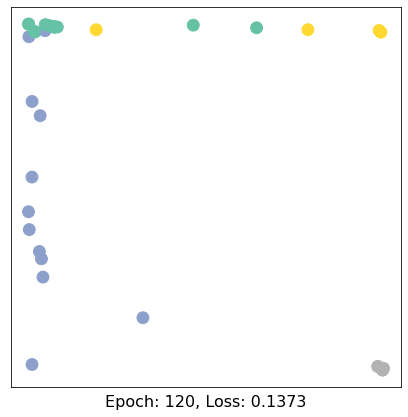

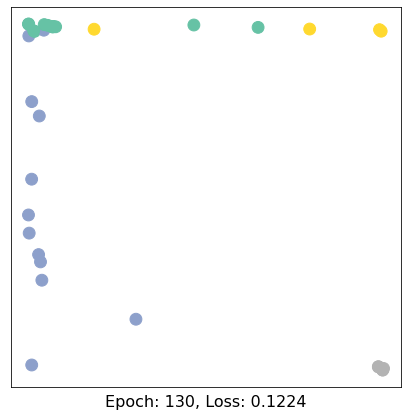

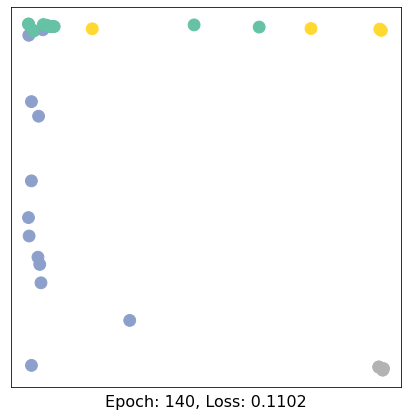

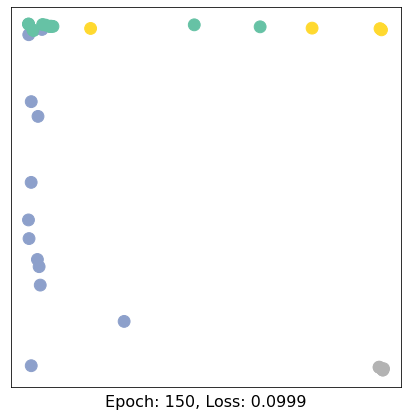

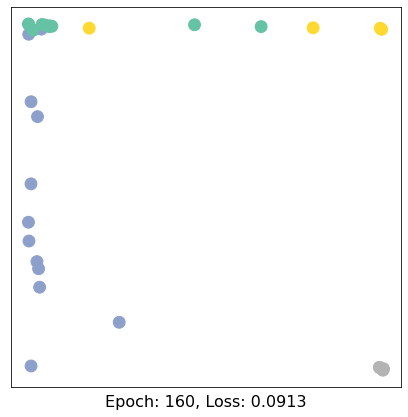

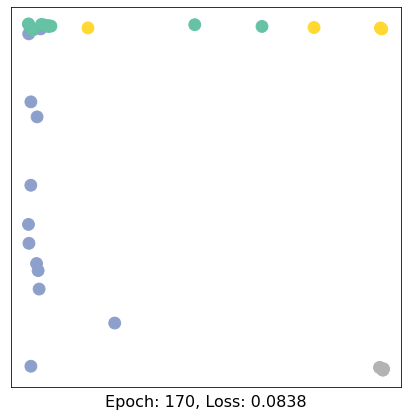

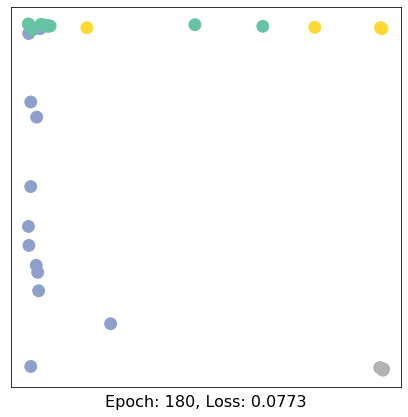

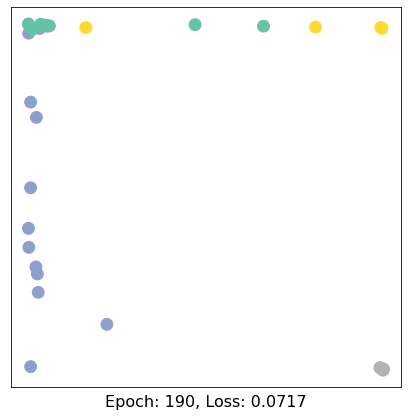

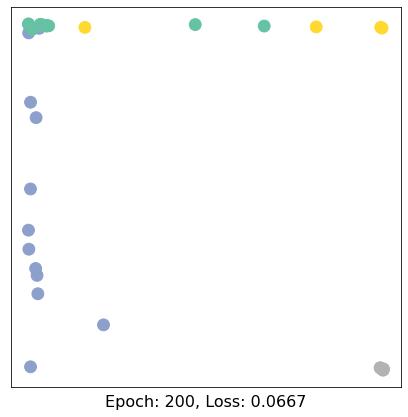

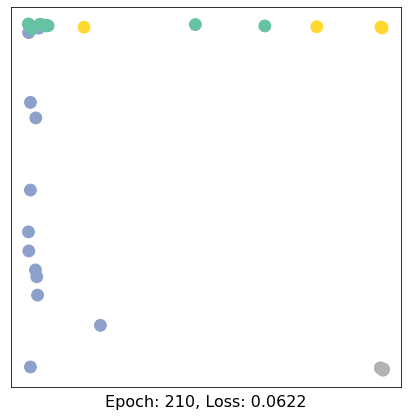

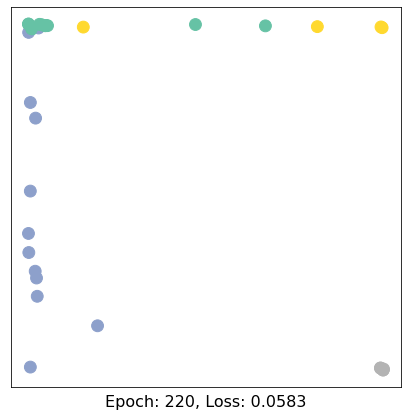

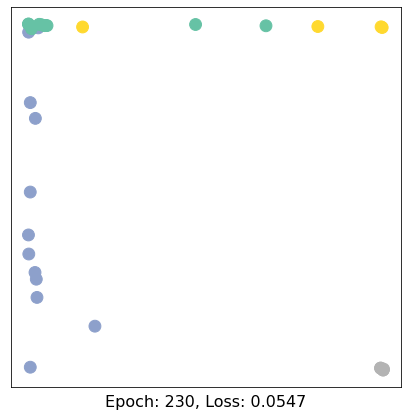

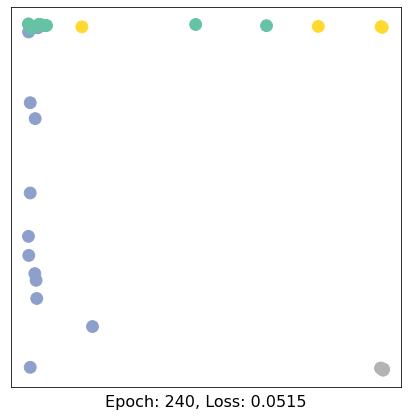

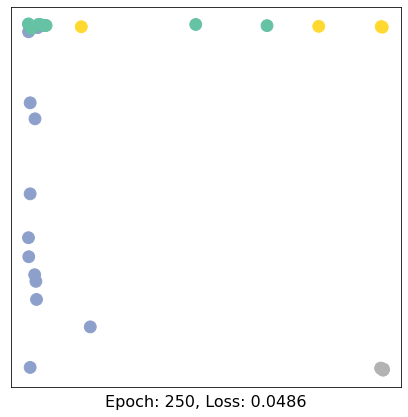

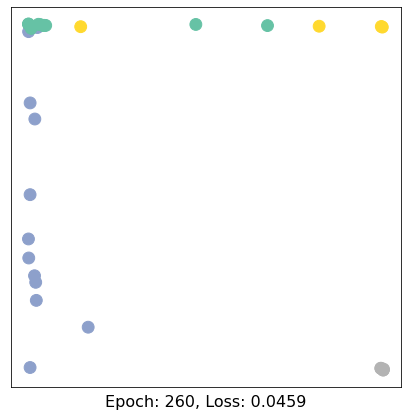

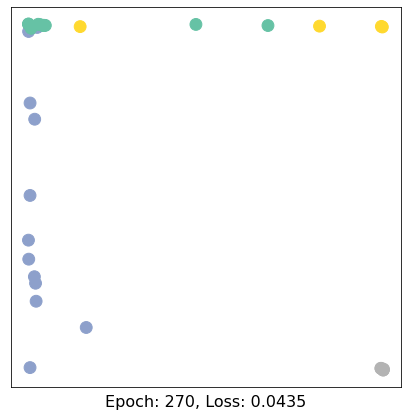

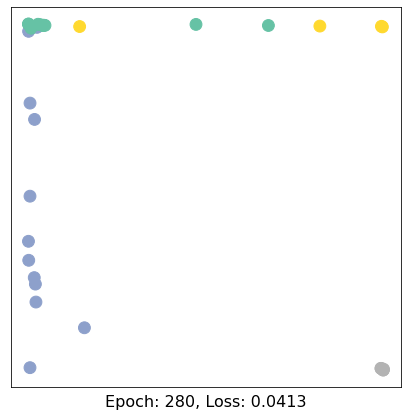

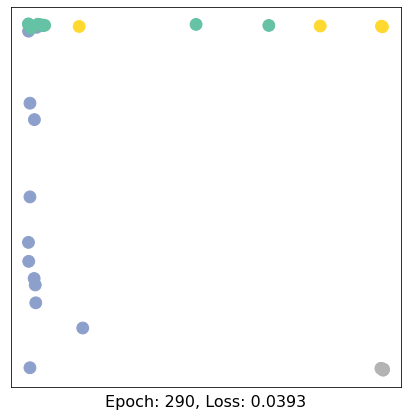

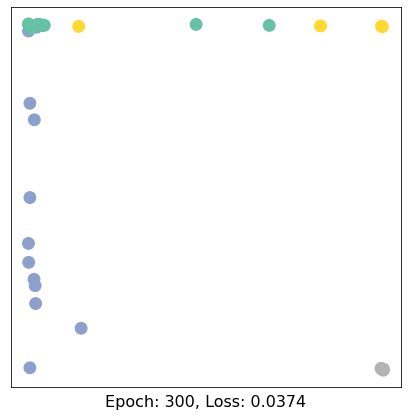

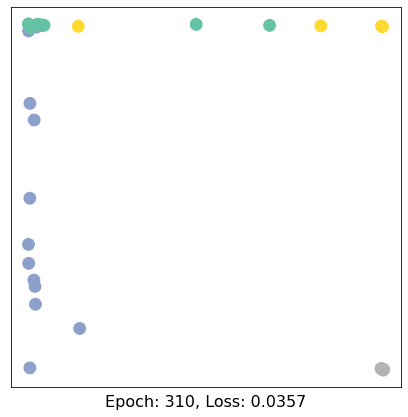

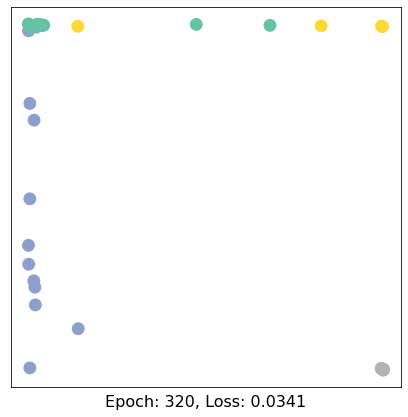

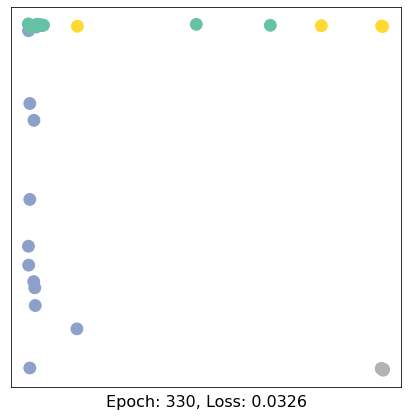

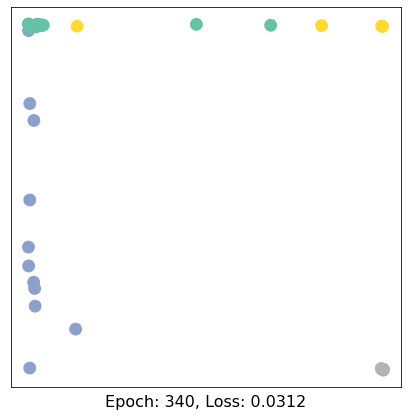

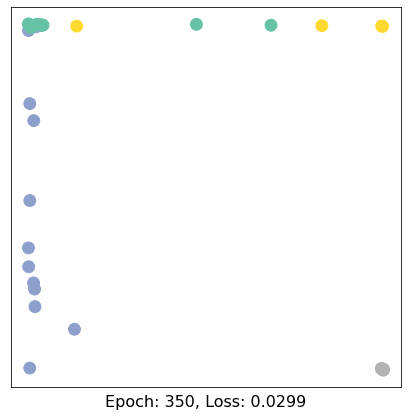

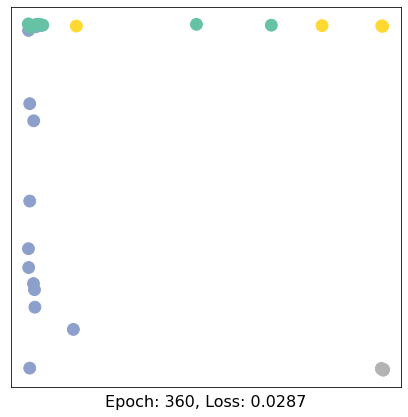

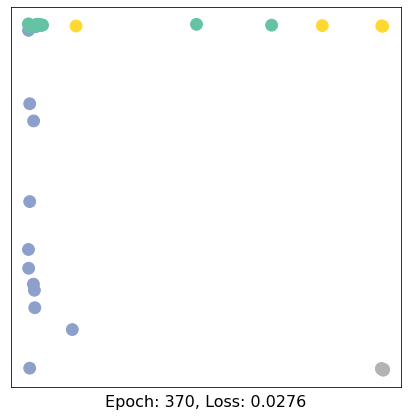

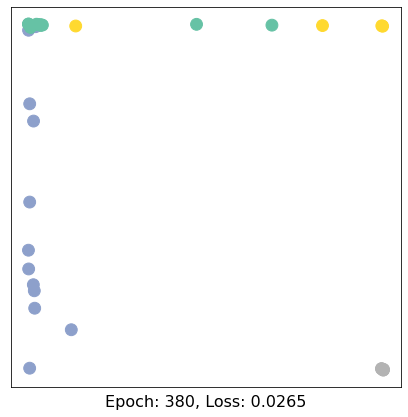

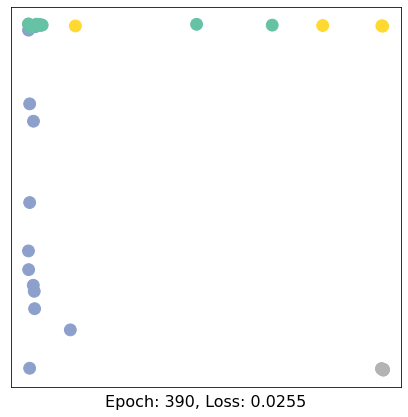

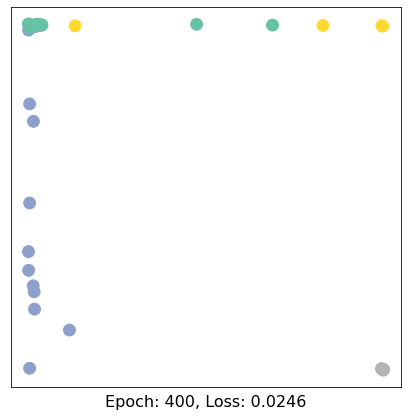

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        print(loss)
        time.sleep(0.3)